In [1]:
import methods.clip as clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

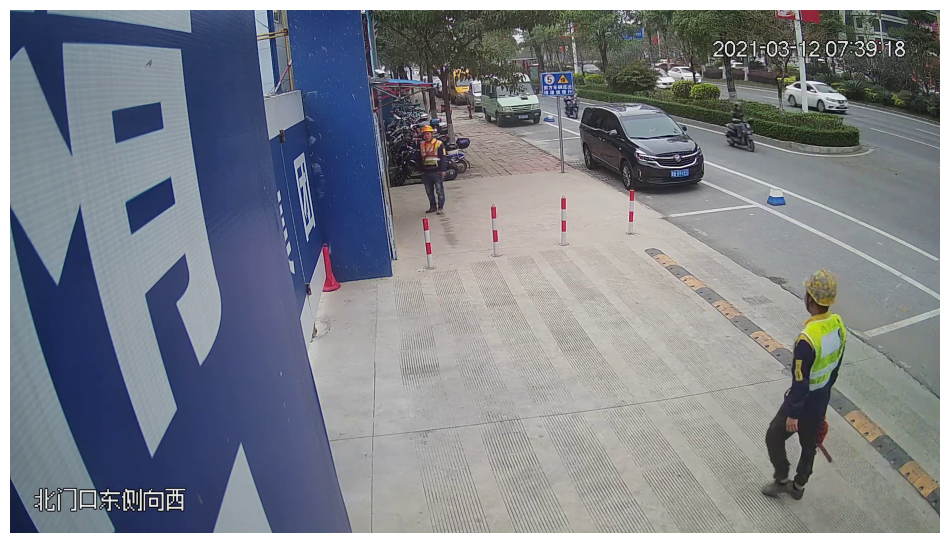

In [2]:
# img = cv2.imread(r"D:/PythonProjects/anviewdata/cvat-cli-output/dataset-split-20230315-1849/images/train/task_0030_000350.png")
img = cv2.imread(r"D:/PythonProjects/anviewdata/cvat-cli-output/dataset-split-20230315-1849/images/train/task_0056_001220.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/16", device=device)
model.eval()
preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

In [4]:
pil_img = Image.open(r"D:/PythonProjects/anviewdata/cvat-cli-output/dataset-split-20230315-1849/images/train/task_0056_001220.png")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
target_texts = ['person','building','car']
print(len(all_texts))

59


torch.Size([1, 197, 512])
torch.Size([59, 512])
torch.Size([1, 197, 59])
CLIP: building


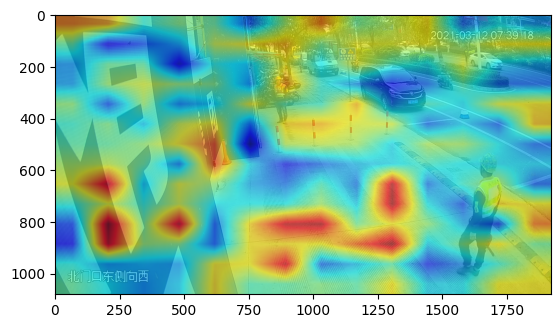

CLIP: car


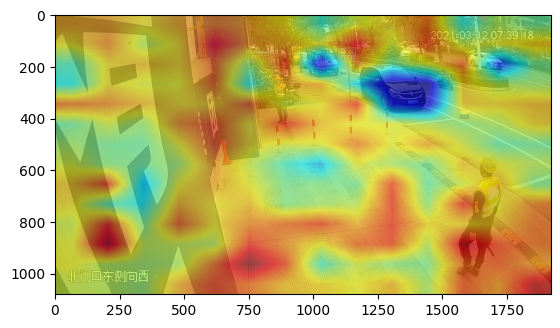

CLIP: person


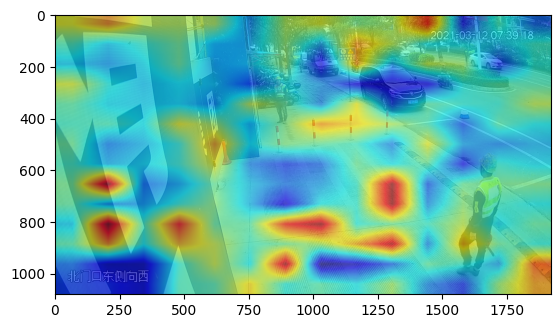

In [5]:
with torch.no_grad():
    # Extract image features
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    print(image_features.shape)
    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)
    print(text_features.shape)

    # Similarity map from image tokens with min-max norm and resize, B,H,W,N
    features = image_features @ text_features.t()
    print(features.shape)
    similarity_map = clip.get_similarity_map(features[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP:', all_texts[n])
            plt.imshow(vis)
            plt.show()

In [6]:
model, preprocess = clip.load("CS-ViT-B/16", device=device)
model.eval()

CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

CLIP Surgery: building


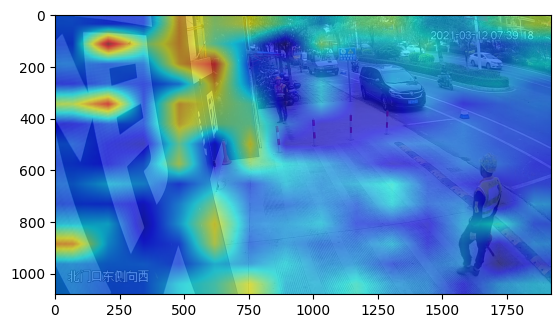

CLIP Surgery: car


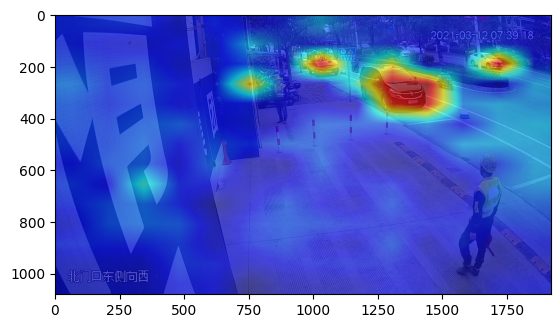

CLIP Surgery: person


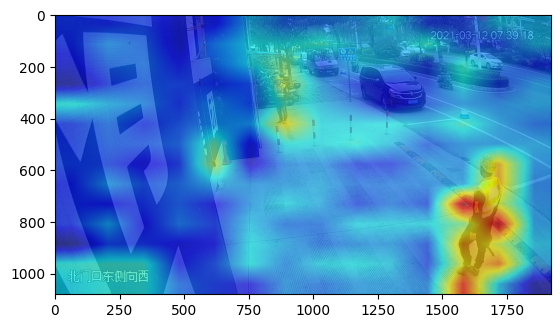

In [7]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery:', all_texts[n])
            plt.imshow(vis)
            plt.show()

In [8]:
texts = ['helmet']

CLIP Surgery for a single text: helmet


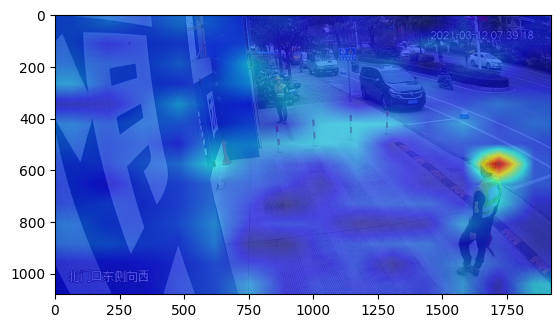

In [9]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # Apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery for a single text:', texts[n])
            plt.imshow(vis)
            plt.show()

In [10]:
sam_checkpoint = r"D:\PythonProjects\anviewdata\cvat-cli\model\sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(np.array(pil_img))

SAM guided by points from CLIP Surgery: building


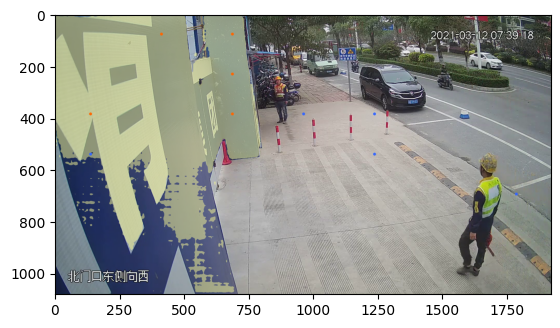

SAM guided by points from CLIP Surgery: car


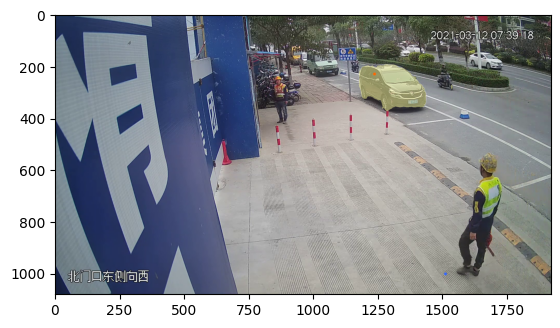

SAM guided by points from CLIP Surgery: person


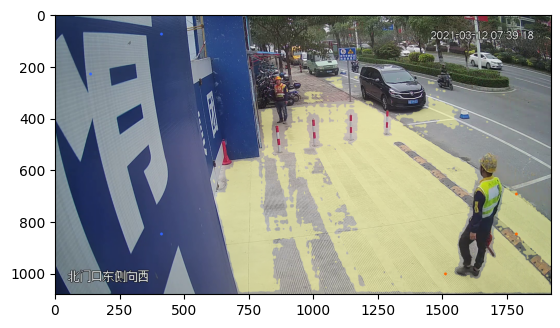

Sometimes, the points are accurate, while the masks from SAM still need improvements.
I mean, some failure cases are not caused by wrong points.


In [11]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image) # Image resized to 512
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery, no batch
    similarity = clip.clip_feature_surgery(image_features, text_features)[0]

    # Inference SAM with points from CLIP Surgery
    for n in range(similarity.shape[-1]):
        if all_texts[n] not in target_texts:
            continue
        points, labels = clip.similarity_map_to_points(similarity[1:, n], cv2_img.shape[:2], t=0.8)
        masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
        mask = masks[np.argmax(scores)]
        mask = mask.astype('uint8')

        # Visualize the results
        vis = cv2_img.copy()
        vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
        for i, [x, y] in enumerate(points):
            cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
        vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
        print('SAM guided by points from CLIP Surgery:', all_texts[n])
        plt.imshow(vis)
        plt.show()
    print('Sometimes, the points are accurate, while the masks from SAM still need improvements.')
    print('I mean, some failure cases are not caused by wrong points.')

In [12]:
texts = ["helmet"]

SAM & CLIP Surgery for single text: helmet


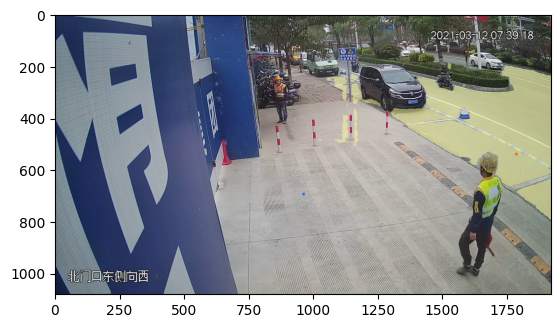

In [13]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # CLIP feature surgery with costum redundant features
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)[0]
    
    # Inference SAM with points from CLIP Surgery
    points, labels = clip.similarity_map_to_points(similarity[1:, 0], cv2_img.shape[:2], t=0.8)
    masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
    mask = masks[np.argmax(scores)]
    mask = mask.astype('uint8')

    # Visualize the results
    vis = cv2_img.copy()
    vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
    for i, [x, y] in enumerate(points):
        cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
    vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
    print('SAM & CLIP Surgery for single text:', texts[0])
    plt.imshow(vis)
    plt.show()